In [6]:
"""NLTKのGutenbergコーパスを用いた著者判定の分析を行うモジュール"""
import os
import re
from pathlib import Path
from os import path
from typing import Final

import nltk
import numpy as np
import shap
from pandas import DataFrame
from dotenv import load_dotenv
from nltk.corpus import gutenberg

from authorship_tool.lgbm.model import LGBMResultModel, LGBMSourceModel
from authorship_tool.lgbm.trainer import learn_until_succeed
from authorship_tool.util import (
    ArrayDimensionReshaper,
    FeatureDatasetGenerator,
    PosFeature,
    TypeGuardUtil,
    PathUtil,
)

load_dotenv()
DATASET_PATH: Final[Path] = Path(PathUtil.PROJECT_ROOT_PATH or "").joinpath(
    os.getenv("path.dataset") or ""
)


nltk.download("gutenberg")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
print()

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\tamukazu.DESKTOP-
[nltk_data]     IL8L9JQ\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\tamukazu.DESKTOP-
[nltk_data]     IL8L9JQ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tamukazu.DESKTOP-
[nltk_data]     IL8L9JQ\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tamukazu.DESKTOP-
[nltk_data]     IL8L9JQ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
DESIRED_SCORE: Final[float] = 0.88
AUTHOR_A: Final[str] = "chesterton"
AUTHOR_B: Final[str] = "austen"

for idx, file_id in enumerate(gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

print()

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt



In [8]:
authors = set()

for file_id in gutenberg.fileids():
    match = re.search(r"^(.+?)-", file_id)
    if match:
        authors.add(match.group(1))

book_data_dict = {}

for index, author in enumerate(authors):
    books = [
        gutenberg.paras(file_id) for file_id in gutenberg.fileids() if author in file_id
    ]

    para_num = len([para for book in books for para in book])
    book_data_dict[author] = para_num

paragraph_num_by_author_num: dict[str, int] = dict(
    sorted(book_data_dict.items(), key=lambda pd: pd[1], reverse=True)
)

for idx, item in enumerate(paragraph_num_by_author_num.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

print()

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs



In [9]:
books_a: list[list[list[list[str]]]] = [
    gutenberg.paras(file_id) for file_id in gutenberg.fileids() if AUTHOR_A in file_id
]

paras_a: list[list[list[str]]] = [para for book in books_a for para in book]

for para in paras_a[:10]:
    print(ArrayDimensionReshaper.para2str(para))
print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n\n")

[ The Ball and The Cross by G . K . Chesterton 1909 ]
I . A DISCUSSION SOMEWHAT IN THE AIR
The flying ship of Professor Lucifer sang through the skies like a silver arrow ; the bleak white steel of it , gleaming in the bleak blue emptiness of the evening . That it was far above the earth was no expression for it ; to the two men in it , it seemed to be far above the stars . The professor had himself invented the flying machine , and had also invented nearly everything in it . Every sort of tool or apparatus had , in consequence , to the full , that fantastic and distorted look which belongs to the miracles of science . For the world of science and evolution is far more nameless and elusive and like a dream than the world of poetry and religion ; since in the latter images and ideas remain themselves eternally , while it is the whole idea of evolution that identities melt into each other as they do in a nightmare .
All the tools of Professor Lucifer were the ancient human tools gone mad

In [10]:
books_b: list[list[list[list[str]]]] = [
    gutenberg.paras(file_id) for file_id in gutenberg.fileids() if AUTHOR_B in file_id
]

paras_b: list[list[list[str]]] = [para for book in books_b for para in book]

for para in paras_b[:10]:
    print(ArrayDimensionReshaper.para2str(para))
print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n\n")

[ Emma by Jane Austen 1816 ]
VOLUME I
CHAPTER I
Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .
She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister ' s marriage , been mistress of his house from a very early period . Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses ; and her place had been supplied by an excellent woman as governess , who had fallen little short of a mother in affection .
Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma . Between _them_ it was more the intimacy of sisters . Even before Miss Taylor had ceased to hold the nominal office of gover

In [11]:
all_paras: list[list[list[str]]] = (
    paras_a + paras_b
    if TypeGuardUtil.are_paras(paras_a) and TypeGuardUtil.are_paras(paras_b)
    else []
)

if not all_paras:
    raise TypeError("paras_a or paras_b is not list[list[list[str]]] type.")

pos_set: set[str] = set(tag for tag in PosFeature(all_paras).add_subcategory().pos_set)

all_pos: list[str] = sorted(pos_set)
print(all_pos)

['$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_pp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [12]:
dataset_generator = FeatureDatasetGenerator(all_pos)
data = []
correctness = []

for para_a in paras_a:
    x, y = dataset_generator.reshape_and_generate(para_a, all_pos, True)
    data.append(x)
    correctness.append(y)

for para_b in paras_b:
    x, y = dataset_generator.reshape_and_generate(para_b, all_pos, False)
    data.append(x)
    correctness.append(y)


df = DataFrame(data, columns=dataset_generator.columns)
nd_correctness = np.array(correctness)

display(df.head(10))

,word variation,uncommon word frequency,sentence length,average word length,$,'',(,),",",.,...,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,0.857143,0.857143,14,2.857143,0.0,0.0,0.000000,0.000000,0.000000,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000,1.000000,8,3.625000,0.0,0.0,0.000000,0.000000,0.000000,0.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.573171,0.530488,164,4.103659,0.0,0.0,0.000000,0.000000,0.042683,0.030488,...,0.018293,0.006098,0.012195,0.006098,0.006098,0.006098,0.0,0.000000,0.000000,0.0
3,0.637584,0.590604,149,4.389262,0.0,0.0,0.000000,0.000000,0.067114,0.040268,...,0.006711,0.006711,0.006711,0.006711,0.000000,0.026846,0.0,0.000000,0.000000,0.0
4,0.544218,0.574830,294,4.125850,0.0,0.0,0.003401,0.003401,0.085034,0.027211,...,0.006803,0.003401,0.003401,0.003401,0.000000,0.003401,0.0,0.003401,0.000000,0.0
5,0.758242,0.593407,91,4.637363,0.0,0.0,0.000000,0.000000,0.032967,0.043956,...,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.0,0.000000,0.000000,0.0
6,0.860000,0.580000,50,3.480000,0.0,0.0,0.000000,0.000000,0.040000,0.000000,...,0.020000,0.000000,0.000000,0.020000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
7,0.485623,0.555911,313,3.638978,0.0,0.0,0.003195,0.000000,0.089457,0.041534,...,0.003195,0.000000,0.003195,0.003195,0.006390,0.006390,0.0,0.000000,0.003195,0.0
8,0.840000,0.680000,25,3.760000,0.0,0.0,0.000000,0.000000,0.080000,0.000000,...,0.040000,0.040000,0.040000,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
9,0.840000,0.800000,25,3.400000,0.0,0.0,0.000000,0.000000,0.120000,0.000000,...,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [13]:
print(df.shape)

(9320, 48)


In [14]:
print(df.dtypes)

word variation             float64
uncommon word frequency    float64
sentence length              int64
average word length        float64
$                          float64
''                         float64
(                          float64
)                          float64
,                          float64
.                          float64
:                          float64
CC                         float64
CD                         float64
DT                         float64
EX                         float64
FW                         float64
IN                         float64
JJ                         float64
JJR                        float64
JJS                        float64
JJ_pp                      float64
MD                         float64
NN                         float64
NNP                        float64
NNPS                       float64
NNS                        float64
PDT                        float64
POS                        float64
PRP                 

In [15]:
print(df.isna().sum())

word variation             0
uncommon word frequency    0
sentence length            0
average word length        0
$                          0
''                         0
(                          0
)                          0
,                          0
.                          0
:                          0
CC                         0
CD                         0
DT                         0
EX                         0
FW                         0
IN                         0
JJ                         0
JJR                        0
JJS                        0
JJ_pp                      0
MD                         0
NN                         0
NNP                        0
NNPS                       0
NNS                        0
PDT                        0
POS                        0
PRP                        0
PRP$                       0
RB                         0
RBR                        0
RBS                        0
RP                         0
SYM           

In [16]:
result: LGBMResultModel = learn_until_succeed(
    LGBMSourceModel(DESIRED_SCORE, df, nd_correctness)
)

[LightGBM] [Info] Number of positive: 3027, number of negative: 3963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9592
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433047 -> initscore=-0.269429
[LightGBM] [Info] Start training from score -0.269429
[LightGBM] [Info] Number of positive: 3063, number of negative: 3927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9582
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.438197 -> initscore=-0.248481
[LightGBM] [Info] Start training from score -0.248481


[LightGBM] [Info] Number of positive: 3047, number of negative: 3943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9583
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435908 -> initscore=-0.257784
[LightGBM] [Info] Start training from score -0.257784
[LightGBM] [Info] Number of positive: 3058, number of negative: 3932
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 6990, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437482 -> initscore=-0.251387
[LightGBM] [Info] Start training from score -0.251387
[LightGBM] [Info] 

In [17]:
print(f"auc-roc score: {result.auc_roc_score}")

auc-roc score: 0.8802349443632009


In [18]:
display(result.pred_crosstab())

col_0,False,True
row_0,,
False,1123,209
True,241,757


In [19]:
result.dump()

In [20]:
explainer = shap.explainers.TreeExplainer(result.model)
test_shap_val = explainer.shap_values(result.test_data)[1]

DataFrame(test_shap_val).to_csv(
    DATASET_PATH.joinpath("test_shap_val.csv"), index=False, header=False
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


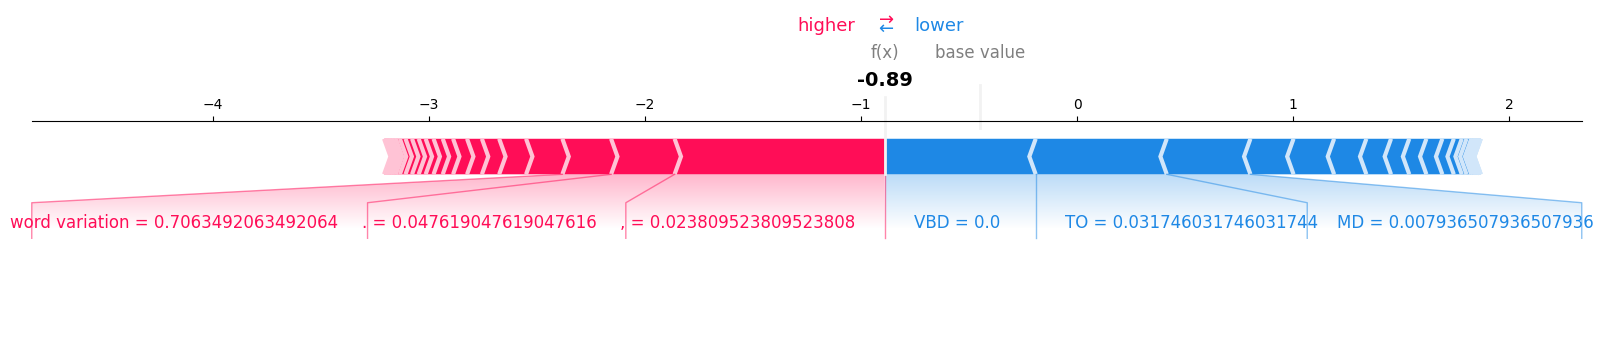

In [21]:
# shap.initjs()
shap.force_plot(
    explainer.expected_value[1],
    test_shap_val[0],
    result.test_data.iloc[0],
    matplotlib=True,
)

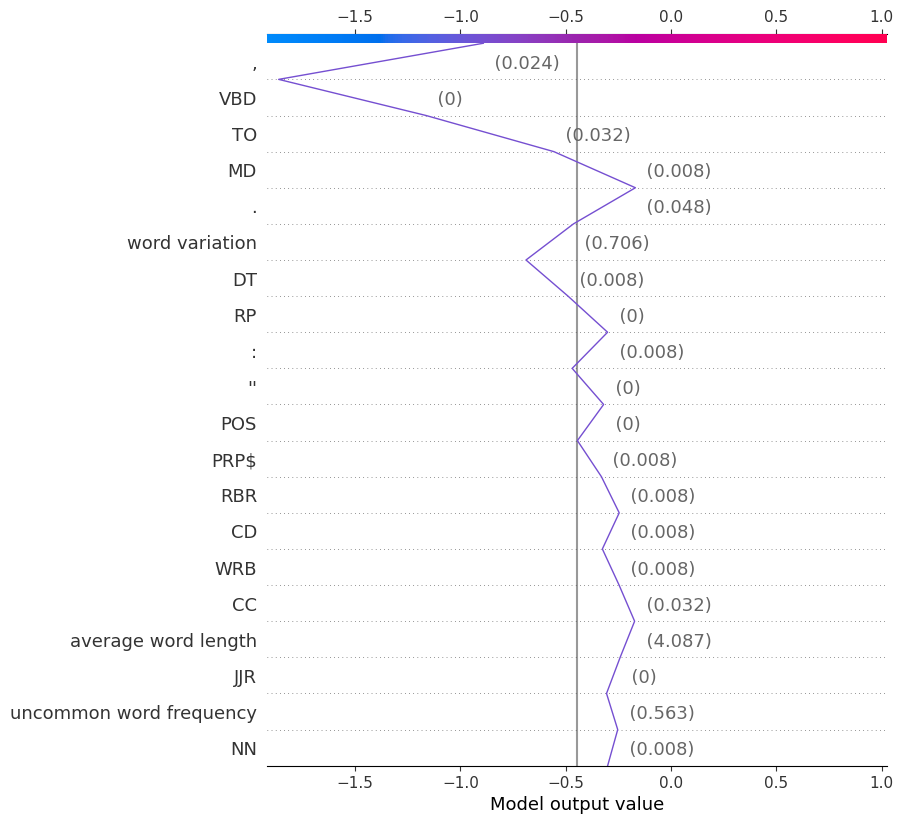

In [22]:
shap.decision_plot(
    explainer.expected_value[1], test_shap_val[0], result.test_data.iloc[0]
)

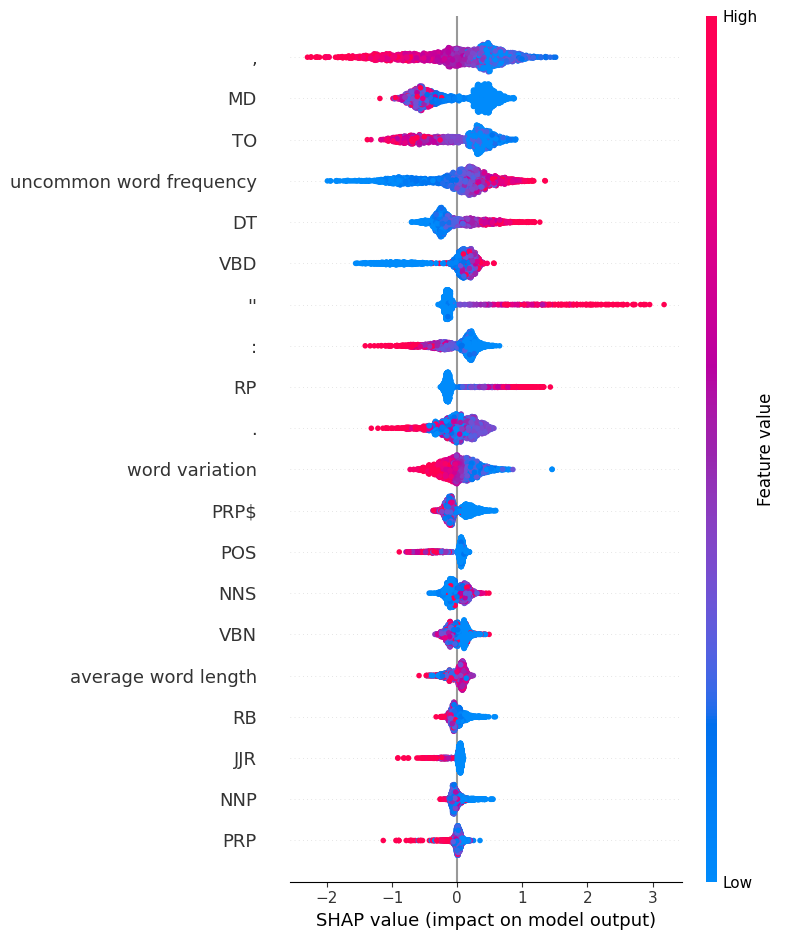

In [23]:
shap.summary_plot(test_shap_val, result.test_data)

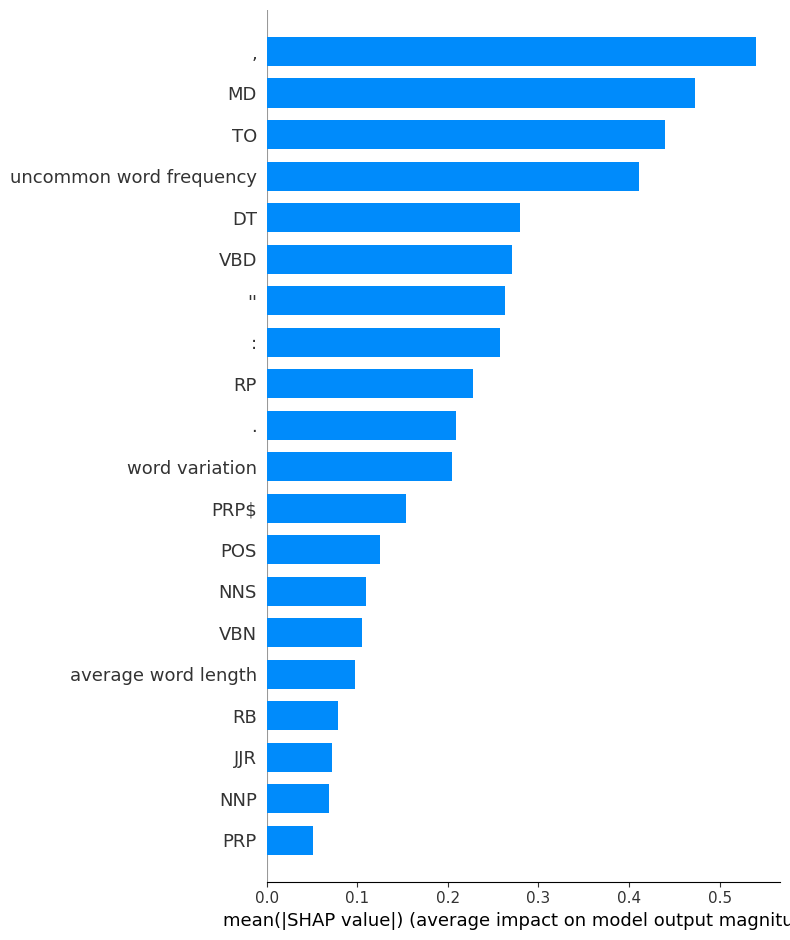

In [24]:
shap.summary_plot(test_shap_val, result.test_data, plot_type="bar")